In [1]:
%matplotlib inline

In [2]:
import os

for foldername in ['plots','plots/propagation','plots/elementary_solutions','plots/validation','plots/time_dependent']:
    try:
        os.mkdir(foldername)
    except:
        pass

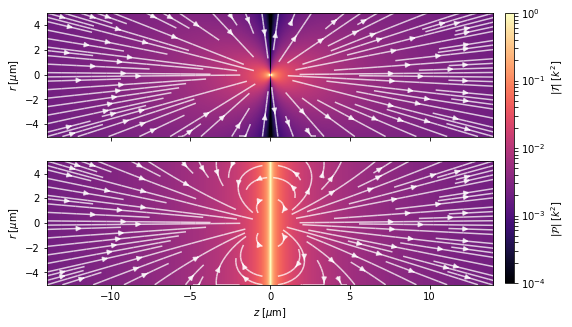

In [3]:
from pypropagate import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pypropagate.colormaps import fire_colormap

# Create settings
settings = presets.settings.create_paraxial_wave_equation_settings()
s = settings.symbols
settings.wave_equation.set_energy(1*units.eV)

# Define simulation box
s.xmin = -5*units.um
s.xmax =  5*units.um
s.zmin = -14*units.um
s.zmax =  14*units.um

s.Nx = 2**13
s.Nz = 2**13

# Define Kernels
r = pc.Symbol('r')
K1 = -s.z/(2*pc.pi*r)*pc.derivative(pc.exp(1j*s.k*r)/r,r).evaluate()
K2 = 1j*s.k/(2*pc.pi*s.z) * pc.exp(-1j*s.k*(s.z+s.x**2/(2*s.z)))

# Plot the kernels
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,5),sharex=True)
K1field = expression_to_array(K1.subs(r,- pc.sign(s.z) * pc.sqrt(s.x**2+s.z**2)) / s.k**2 * pc.exp(-1j*pc.pi),settings) 
K2field = expression_to_array(K2/ s.k**2,settings)
img = plot(abs(K1field),ax=ax1,norm=LogNorm(10**-4),vmax=1,cmap='magma')
support_1 = s.x**2+s.z**2 > units.um**2
poynting_streamplot(K1field,0,ax=ax1,color=(1,1,1,0.75),settings=settings,support=support_1,density=1)
ax1.set_xlabel('')
ax1.set_ylabel(r'$r\;[\mu\mathrm{m}]$')
img = plot(abs(K2field),ax=ax2,norm=LogNorm(10**-4),vmax=1,cmap='magma')
support_2 = support_1 & (abs(s.z) > 0.2 * units.um)
poynting_streamplot(K2field,0,ax=ax2,color=(1,1,1,0.75),settings=settings,support=support_2,density=1)
ax2.set_ylabel(r'$r\;[\mu\mathrm{m}]$')
cbar_ax = fig.add_axes([0.92, 0.13, 0.015, 0.75])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label('$|\mathcal{P}| \; [k^2] \hspace{11} |\mathcal{T}| \; [k^2]$')

plt.savefig('plots/propagation/kernels.pdf',bbox_extra_artists=(cbar_ax,), bbox_inches='tight',transparent=True)

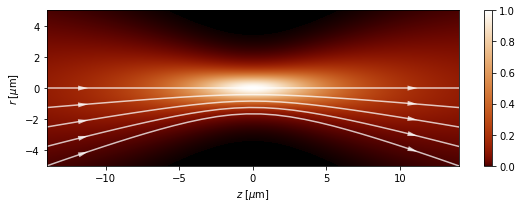

In [4]:
from pypropagate import *
from pypropagate.colormaps import fire_colormap
import matplotlib.pyplot as plt

# Create settings
settings = presets.settings.create_paraxial_wave_equation_settings()
s = settings.symbols

# Define simulation box
s.xmin = -5*units.um
s.xmax =  5*units.um
s.zmin = -14*units.um
s.zmax =  14*units.um
s.Nx = 2**10
s.Nz = 2**10

# Define gaussian beam
r = pc.Symbol('r')
sr = pc.Symbol('sigma_r')
w = pc.sqrt(s.z/(1j*s.k) + sr**2)
gauss = pc.exp(-1j*s.k*s.z) * sr**2/w**2 * pc.exp(-r**2/(2*w**2))
settings.wave_equation.set_energy(1*units.eV)

# Plot the beam
field = expression_to_array(gauss.subs([(sr,1*units.um),(r,s.x)]),settings)
fig,(ax) = plt.subplots(1,1,figsize=(8,3))
uimg = plot(abs(field)**2,ax=ax,vmax=1,cmap=fire_colormap())
poynting_streamplot_with_start_points(field,0,[[s.zmin,i*s.xmin] for i in np.linspace(0,1,5)],ax=ax,color=(1,1,1,0.75),arrowsize=5,arrowpositions=[0.1,0.9])
plt.colorbar(uimg)
plt.ylabel('$r\;[\mu\mathrm{m}]$')
plt.tight_layout()

plt.savefig('plots/elementary_solutions/gaussian.pdf',transparent=True)

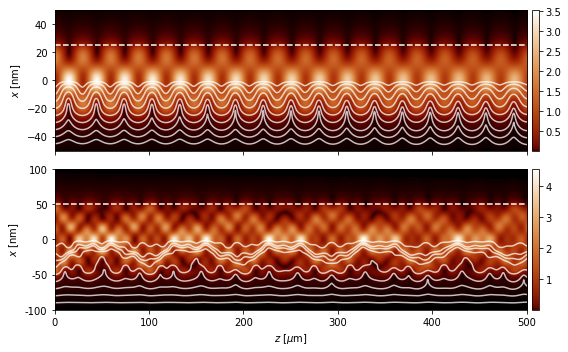

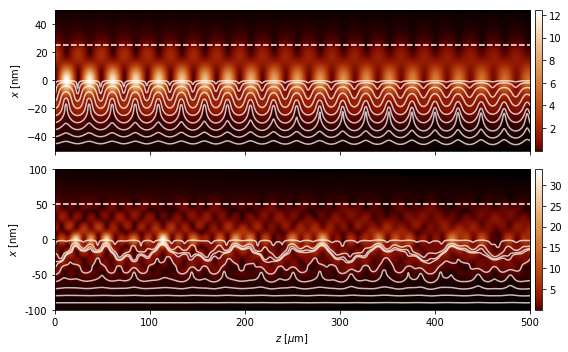

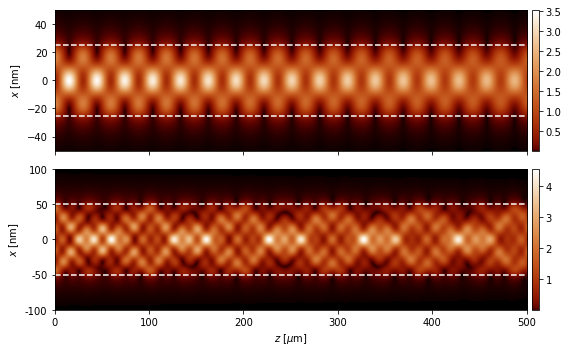

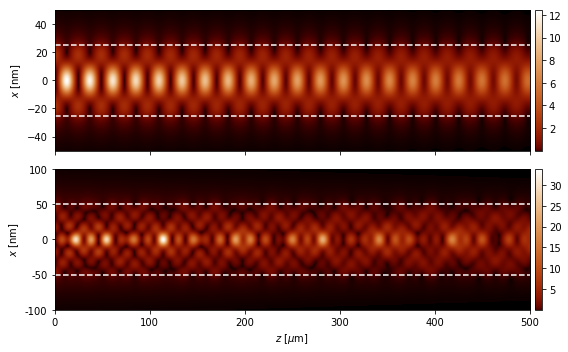

In [5]:
from pypropagate import *
from pypropagate.colormaps import fire_colormap
import matplotlib.pyplot as plt
from analytical_waveguides import * 
from mpl_toolkits.axes_grid1 import make_axes_locatable

def analytical_waveguide(slab_waveguide,plot_poynting_streamlines,path = None):
    # Define waveguide
    settings = presets.settings.create_paraxial_wave_equation_settings(fresnel_compatible = True)
    presets.boundaries.set_plane_wave_initial_conditions(settings)
    s = settings.symbols
    wg = settings.create_category('waveguide')
    wg.create_symbol('n_1')
    wg.create_symbol('n_2')
    wg.create_symbol('r')
    wg.create_symbol('l')
    s.n = pc.piecewise((wg.n_1,s.x**2+s.y**2<=wg.r**2),(wg.n_2,True))

    # Set paramters
    wg.n_1 = 1
    wg.n_2 = presets.medium.create_material('Ge',settings)
    wg.l = 0.6*units.mm
    settings.wave_equation.set_energy(10*units.keV)
    settings.simulation_box.set((4*wg.r,0,0.5*units.mm),(1000,0,1000))

    # Plot 
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,5),sharex=True)
    wg.r = 25*units.nm
    field = analytical_slab_waveguide(settings) if slab_waveguide else analytical_circular_waveguide(settings) 
    im = plot(field,ax=ax1,interpolation='bilinear',cmap=fire_colormap())
    if plot_poynting_streamlines:
        start_points = [[0,i*-2*wg.r] for i in np.linspace(0.1,1,10)]
        stream = poynting_streamplot_with_start_points(field,s.k,start_points,color=(1,1,1,0.75),arrowpositions=[],ax=ax1)
    else:
        ax1.plot([0,500],[-25,-25],'--',color=(1,1,1))
    ax1.plot([0,500],[25,25],'--',color=(1,1,1))
    ax1.set_ylim(-2*25,2*25)
    ax1.set_xlim(0,500)
    ax1.set_xlabel('')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", "1.5%", pad="1%")
    plt.colorbar(im, cax=cax)
    wg.r = 50*units.nm
    field = analytical_slab_waveguide(settings) if slab_waveguide else analytical_circular_waveguide(settings) 
    im = plot(field,ax=ax2,interpolation='bilinear',cmap=fire_colormap())
    if plot_poynting_streamlines:
        start_points = [[0,i*-2*wg.r] for i in np.linspace(0.1,1,10)]
        stream = poynting_streamplot_with_start_points(field,s.k,start_points,color=(1,1,1,0.75),arrowpositions=[],ax=ax2)
    else:
        ax2.plot([0,500],[-50,-50],'--',color=(1,1,1))
    ax2.plot([0,500],[50,50],'--',color=(1,1,1))
    ax2.set_yticklabels([-100,-50,0,50,100])
    ax2.set_ylim(-100,100)
    ax2.set_ylabel(r'$x$ [$\mathrm{nm}$]')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", "1.5%", pad="1%")
    plt.colorbar(im, cax=cax)
    plt.tight_layout()
    if path: plt.savefig(path,transparent=True) 
    plt.show()

analytical_waveguide(True,True,'plots/elementary_solutions/slab_waveguide_anal_25-50nm_poynting.pdf')
analytical_waveguide(False,True,'plots/elementary_solutions/circ_waveguide_anal_25-50nm_poynting.pdf')
analytical_waveguide(True,False,'plots/elementary_solutions/slab_waveguide_anal_25-50nm.pdf')
analytical_waveguide(False,False,'plots/elementary_solutions/circ_waveguide_anal_25-50nm_poynting.pdf')

Running FiniteDifferences2D...
propagating:|█████████████████████████| 49/49 [0.1s < 0(0)s]]
Running Fresnel2D...
propagating:|█████████████████████████| 49/49 [0.0s < 0(0)s]]
Running FiniteDifferences3D...
propagating:|█████████████████████████| 49/49 [9.9s < 0(0)s]]
Running Fresnel3D...
propagating:|█████████████████████████| 49/49 [5.9s < 0(0)s]]
Running FiniteDifferencesCS...
propagating:|█████████████████████████| 49/49 [0.1s < 0(0)s]]
Running FresnelCS...
propagating:|█████████████████████████| 49/49 [5.7s < 0(0)s]]


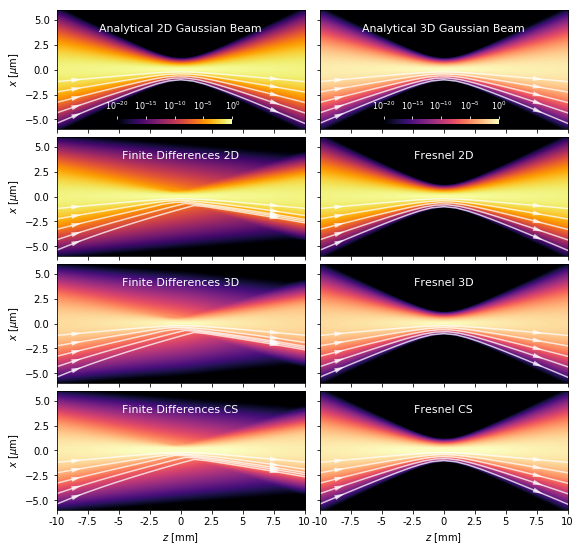

Running FiniteDifferences2D...
propagating:|███████████████████████| 999/999 [0.3s < 0(0)s]]
Running Fresnel2D...
propagating:|███████████████████████| 999/999 [0.3s < 0(0)s]]
Running FiniteDifferences3D...
propagating:|█████████████████████| 999/999 [202.1s < 0(0)s]]
Running Fresnel3D...
propagating:|█████████████████████| 999/999 [121.3s < 0(0)s]]
Running FiniteDifferencesCS...
propagating:|███████████████████████| 999/999 [0.6s < 0(0)s]]
Running FresnelCS...
propagating:|█████████████████████| 999/999 [112.6s < 0(0)s]]


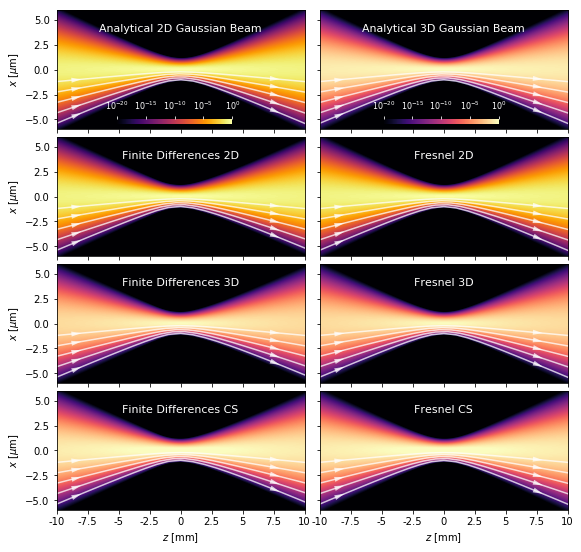

In [6]:
def gaussian_beam_validation(Nz,path=None):
    from pypropagate import np,pc,presets,propagators,plot
    import matplotlib.pyplot as plt
    from pypropagate.colormaps import ice_colormap
    from pypropagate.plot import get_metric_prefix,get_unitless_bounds
    from matplotlib.colors import LogNorm
    from matplotlib.ticker import FuncFormatter
    import warnings

    # Define the gaussian beam settings
    settings = presets.settings.create_paraxial_wave_equation_settings()
    s = settings.symbols
    r = pc.sqrt(s.x**2+s.y**2)
    g = settings.create_category('gaussian',info='Parameters of the gaussian beam')
    g.create_symbol('w_0',type=pc.Types.Real,positive=True,info = 'Waist size at z = 0')
    g.create_function('w_r',(s.z,),pc.sqrt(2)*pc.sqrt((g.w_0)**2/2-2j/(2*s.k)*s.z),info = 'Waist size')
    g.create_function('u3D',(s.x,s.y,s.z),(g.w_0)**2/g.w_r**2*pc.exp(-(r**2)/(g.w_r**2)),info='3D Gaussian')
    g.create_function('u2D',(s.x,s.y,s.z), (g.w_0)/g.w_r*pc.exp(-(s.x**2)/(g.w_r**2)),info='2D Gaussian')

    # Set paramters and simulation box
    g.w_0 = 0.25*units.um
    s.n = 1
    s.u_boundary = 0
    s.zmin = -s.sz/2
    settings.wave_equation.set_energy(12*units.keV)
    s.xmin = s.ymin = -10*units.um
    s.xmax = s.ymax = 10*units.um
    s.zmin = -10*units.mm
    s.zmax = 10*units.mm    
    s.Nx = s.Ny = 2**11
    s.Nz = Nz

    # Propagate
    fields = [ expression_to_array(g.u2D,settings) , expression_to_array(g.u2D.subs(s.y,0),settings) ]    
    names = ['Analytical 2D Gaussian Beam','Analytical 3D Gaussian Beam','Finite Differences 2D','Fresnel 2D','Finite Differences 3D','Fresnel 3D','Finite Differences CS','Fresnel CS']
    propagators = [propagators.FiniteDifferences2D,propagators.Fresnel2D,propagators.FiniteDifferences3D,propagators.Fresnel3D,propagators.FiniteDifferencesCS,propagators.FresnelCS]
    for prop in propagators: 
        print "Running %s..." % prop.__name__
        if prop.ndim == 1:
            s.u0 = g.u2D
            propagator = prop(settings)
            field = propagator.run_slice()[::s.sx/1000,:]
        else: 
            s.u0 = g.u3D
            propagator = prop(settings)
            field = propagator.run_slice()[::s.sx/1000,0,:]
        fields.append(field)

    # Plot
    fig,axes = plt.subplots(4,2,figsize=(4*2,2.5*3),sharex=True,sharey=True)
    start_points = [(s.zmin,-6*i*units.um) for i in np.linspace(0.2,0.9,5)]
    for idx,(field,label) in enumerate(zip(fields,names)): 
        if field is None:
            ax.set_xlabel('')
            ax.set_ylabel('')
            continue
        i = idx%2
        j = idx/2
        ax = axes[j][i]
        field = field[-6*units.um:6*units.um]
        cmap = 'inferno' if idx in [0,2,3] else 'magma'
        im = plot(field + 1e-50,ax=ax,vmax=1,norm=LogNorm(10**-20),cmap=cmap)
        poynting_streamplot_with_start_points(field,s.k,start_points,ax=ax,color=(1,1,1,0.75) )
        ax.text(0.5, 0.8, label,verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='white', fontsize=11)
        if idx in [0,1]:
            pos = ax.get_position()
            cbaxes = fig.add_axes([pos.xmin+(0.08 if idx is 0 else 0.12),pos.ymin + 0.065,0.2,0.01]) 
            cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
            cbaxes.tick_params(axis='x', colors='white')
            for pos in ['top', 'bottom', 'right', 'left']:
                cbaxes.spines[pos].set_edgecolor('white')
            cbar.outline.set_visible(False)
            cbar.set_ticks([10**-20,10**-15,10**-10,10**-5,1])
            cbaxes.tick_params(labelsize=8) 
            cbaxes.xaxis.set_ticks_position('top')
            cbaxes.xaxis.set_label_position('top')
        if j != 3: ax.set_xlabel('')
        else: ax.xaxis.set_major_formatter(FuncFormatter(lambda x,p:"%i" % x if x%1==0 else '%s' % x))
        if i != 0: ax.set_ylabel('')

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
    plt.subplots_adjust(left=0.1)
    
    if path is not None:
        plt.savefig(path,transparent=True)
    plt.show()
        
gaussian_beam_validation(50,'plots/validation/free_space_gaussian_large_step.pdf')
gaussian_beam_validation(1000,'plots/validation/free_space_gaussian.pdf')

dx, dr = 0.733138 nm	dz = 0.800801 um
Running FiniteDifferences2D...
propagating:|███████████████████████| 999/999 [0.2s < 0(0)s]]
Running Fresnel2D...
propagating:|███████████████████████| 999/999 [0.3s < 0(0)s]]
Running FiniteDifferences3D...
propagating:|██████████████████████| 999/999 [44.4s < 0(0)s]]
Running Fresnel3D...
propagating:|██████████████████████| 999/999 [34.7s < 0(0)s]]
Running FiniteDifferencesCS...
propagating:|███████████████████████| 999/999 [0.3s < 0(0)s]]
Running FresnelCS...
propagating:|██████████████████████| 999/999 [17.5s < 0(0)s]]


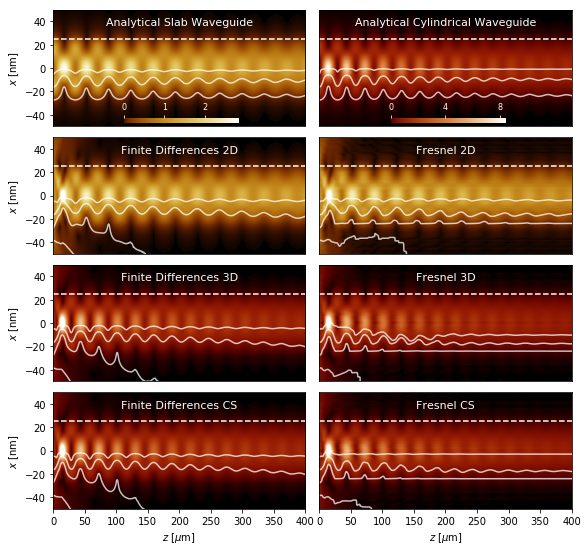

dx, dr = 0.733138 nm	dz = 0.016000 um
Running FiniteDifferences2D...
propagating:|███████████████████████| 999/999 [4.2s < 0(0)s]]
Running Fresnel2D...
propagating:|███████████████████████| 999/999 [6.1s < 0(0)s]]
Running FiniteDifferences3D...
propagating:|████████████████████| 999/999 [2228.4s < 0(0)s]]
Running Fresnel3D...
propagating:|████████████████████| 999/999 [1722.7s < 0(0)s]]
Running FiniteDifferencesCS...
propagating:|██████████████████████| 999/999 [12.0s < 0(0)s]]
Running FresnelCS...
propagating:|█████████████████████| 999/999 [610.2s < 0(0)s]]


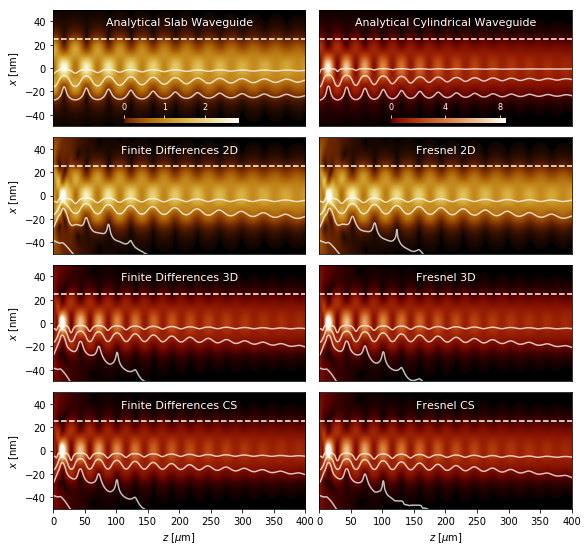

dx, dr = 1.466276 nm	dz = 0.016000 um
Running FiniteDifferences2D...
propagating:|███████████████████████| 999/999 [4.2s < 0(0)s]]
Running Fresnel2D...
propagating:|███████████████████████| 999/999 [6.3s < 0(0)s]]
Running FiniteDifferences3D...
propagating:|████████████████████| 999/999 [1947.6s < 0(0)s]]
Running Fresnel3D...
propagating:|████████████████████| 999/999 [1719.5s < 0(0)s]]
Running FiniteDifferencesCS...
propagating:|██████████████████████| 999/999 [12.4s < 0(0)s]]
Running FresnelCS...
propagating:|█████████████████████| 999/999 [599.8s < 0(0)s]]


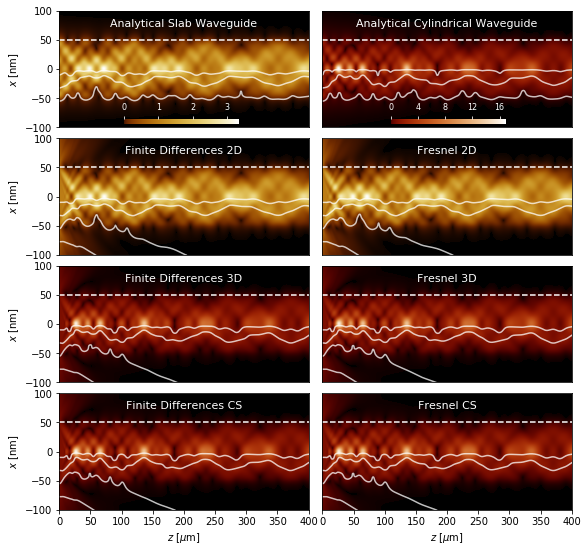

In [7]:
from pypropagate import *

def waveguide_validation(Nx,Nz,radius,path=None,live_plot=False):
    from pypropagate.colormaps import fire_colormap
    import matplotlib.pyplot as plt
    from analytical_waveguides import analytical_circular_waveguide,analytical_slab_waveguide
    import warnings

    # Define waveguide settings
    settings = presets.settings.create_paraxial_wave_equation_settings(fresnel_compatible = True)
    s = settings.symbols
    wg = settings.create_category('waveguide')
    wg.create_symbol('n_1')
    wg.create_symbol('n_2')
    wg.create_symbol('r')
    wg.create_symbol('l')
    s.n = pc.piecewise((wg.n_1,s.x**2+s.y**2<=wg.r**2),(wg.n_2,True))
    wg.n_1 = 1
    wg.n_2 = presets.medium.create_material('Ge',settings)
    wg.r = radius
    wg.l = 0.6*units.mm
    settings.wave_equation.set_energy(12*units.keV)
    s.u0 = pc.exp(-(s.x**2 + s.y**2) / (2 * (2*wg.r)**2)) 
    s.u_boundary = 0

    # Propagate
    settings.simulation_box.set((30*wg.r,30*wg.r,0.8*units.mm),(2**10,2**10,Nz))
    print "dx, dr = %f nm\tdz = %f um" % (settings.get_numeric(s.dx/units.nm),settings.get_numeric(s.dz/units.um))
    fields = [ analytical_slab_waveguide(settings)[-2*wg.r:2*wg.r] , analytical_circular_waveguide(settings)[-2*wg.r:2*wg.r] ]
    names = ['Analytical Slab Waveguide','Analytical Cylindrical Waveguide','Finite Differences 2D','Fresnel 2D','Finite Differences 3D','Fresnel 3D','Finite Differences CS','Fresnel CS']
    props = [propagators.FiniteDifferences2D,propagators.Fresnel2D,propagators.FiniteDifferences3D,propagators.Fresnel3D,propagators.FiniteDifferencesCS,propagators.FresnelCS]
    for prop in props: 
        print "Running %s..." % prop.__name__
        if prop.ndim == 2:
            propagator = prop(settings)
            field = propagator.run_slice(display_progress=True)[-2*wg.r:2*wg.r:wg.r/500,0,::s.sz/1000]
        else: 
            propagator = prop(settings)
            field = propagator.run_slice(display_progress=True)[-2*wg.r:2*wg.r:wg.r/500,::s.sz/1000]
        fields.append(field)
        if live_plot:
            plot_poynting(field,s.k,figsize=(15,4))

    # Plot
    fig,axes = plt.subplots(4,2,figsize=(4*2,2.5*3),sharex=True,sharey=True)
    max2D = (abs(fields[0])**2).max()
    max3D = (abs(fields[1])**2).max()

    for idx,field,label in zip(range(len(fields)),fields,names):     
        i = idx%2
        j = idx/2
        ax = axes[j][i]
        vmax = max2D if idx in [0,2,3] else max3D
        cmap = fire_colormap(hue_shift = 0.05 if idx in [0,2,3] else 0)
        im = plot(abs(field)**2,ax=ax,vmax=vmax,vmin=0,interpolation='bilinear',cmap=cmap)
        support = expression_for_array(s.x<0,field,settings)
        if idx in [0,1]:
            cbarmask = expression_for_array(pc.Or(s.x>-60 * units.nm,s.z<200*units.um),field,settings)
            support.data = np.logical_and( support.data , cbarmask.data )
        start_points = [[0,sp*-2*radius] for sp in np.linspace(0.1,1,5)]
        if idx in [0,1]:
            start_points = start_points[:-2]
        else:
            start_points = start_points[:-1]
        stream = poynting_streamplot_with_start_points(field,s.k,start_points,color=(1,1,1,0.75),ax=ax,arrowpositions=[])
        ax.text(0.5, 0.85, label,verticalalignment='bottom', horizontalalignment='center', transform=ax.transAxes, color='white', fontsize=11)
        if idx in [0,1]:
            pos = ax.get_position()
            cbaxes = fig.add_axes([pos.xmin+(0.08 if idx is 0 else 0.12),pos.ymin + 0.065,0.2,0.01]) 
            cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
            cbaxes.tick_params(axis='x', colors='white')
            for pos in ['top', 'bottom', 'right', 'left']:
                cbaxes.spines[pos].set_edgecolor('white')
            cbar.outline.set_visible(False)
            cbar.set_ticks([k*(1 if idx in [0,2,4] else 4) for k in range(10)])
            cbaxes.tick_params(labelsize=8) 
            cbaxes.xaxis.set_ticks_position('top')
            cbaxes.xaxis.set_label_position('top')
        ax.plot([0,400],[float(radius/units.nm),float(radius/units.nm)],'w--')
        ax.set_ylim(-2*float(radius/units.nm),2*float(radius/units.nm))
        ax.set_xlim(0,400)
        if j != 3:
            ax.set_xlabel('')
            plt.setp(ax.get_xticklines(), visible=False)
        if i == 1: 
            ax.set_ylabel('')
            plt.setp(ax.get_yticklines(), visible=False)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
    if path: plt.savefig(path,transparent=True) 
    plt.show()
        
waveguide_validation(2**10,1000,25*units.nm,'plots/validation/waveguide_prop_25nm_large_step.pdf')
waveguide_validation(2**10,50000,25*units.nm,'plots/validation/waveguide_prop_25nm.pdf')
waveguide_validation(2**10,50000,50*units.nm,'plots/validation/waveguide_prop_50nm.pdf')

dx = 0.352547 nm	dz = 0.050005 um
propagating:|█████████████████████| 4999/4999 [9.0s < 0(0)s]]
dx = 0.040004 nm	dz = 0.050005 um
propagating:|█████████████████████| 4999/4999 [7.7s < 0(0)s]]


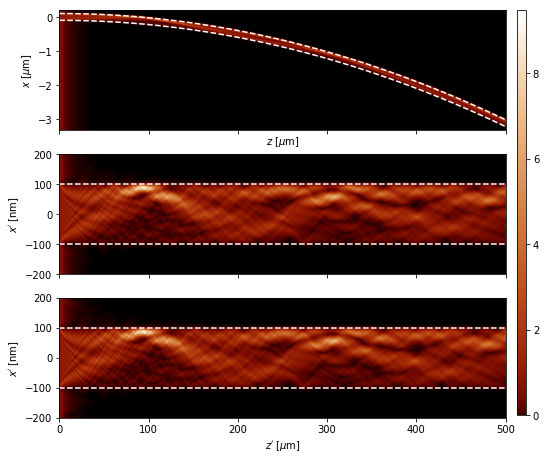

In [8]:
from pypropagate import *
from pypropagate.colormaps import fire_colormap
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define waveguide
settings = presets.settings.create_paraxial_wave_equation_settings()
s = settings.symbols
wg = settings.create_category('waveguide')
wg.create_symbol('n_inside')
wg.create_symbol('n_outside')
wg.create_symbol('r')
wg.create_symbol('d')
wg.create_symbol('R')
wg.create_function('center_x',(s.z,))
wg.center_x = pc.sqrt(wg.R**2 - s.z**2) - wg.R
dist_from_center = pc.sqrt((s.x - wg.center_x)**2 + s.y**2)
s.n = pc.piecewise((wg.n_inside,pc.Or(pc.And(abs(s.x - wg.center_x) < wg.r,s.y >= -wg.d)),s.y > 0),(wg.n_outside,True))
settings.get(s.n)
wg.n_inside = 1
wg.n_outside = presets.medium.create_material('Ta',settings)
wg.d = wg.r
wg.r = 100*units.nm
wg.R = 40*units.mm
s.zmin = 0
s.zmax = 0.5 * units.mm
s.xmax = wg.center_x.subs(s.z,0) + 2*wg.r
s.xmin = wg.center_x.subs(s.z,s.zmax) - 2*wg.r
s.Nx = 10000
s.Nz = 10000
settings.wave_equation.set_energy(7.9*units.keV)
presets.boundaries.set_plane_wave_initial_conditions(settings)
print "dx = %f nm\tdz = %f um" % (settings.get_numeric(s.dx/units.nm),settings.get_numeric(s.dz/units.um))
propagator = propagators.FiniteDifferences2D(settings)
field_cartesian = propagator.run_slice()[::s.sx/4000,::s.sz/4000]

# Data for plot
wg_center = abs(expression_to_array(wg.center_x/units.um,settings).data)
wg_r = settings.get_as(wg.r/units.um,float)
zvalues = abs(expression_to_array(s.z/units.um,settings).data)

# Piecewise paraxial propagation
def create_curvature_initializer(R):
    def curvature_initializer(settings):
        s = settings.symbols
        alpha = settings.get_as(-pc.atan(s.dz/R),float)
        update_field = expression_to_array(pc.exp(1j*s.k*s.x*pc.sin(alpha)),settings).data
        def curvature_updater(propagator):
            field = propagator._get_field()
            field *= update_field
        settings.updaters['curvature'] = curvature_updater
    return curvature_initializer

settings.initializers['curvature'] = create_curvature_initializer(wg.R)

# Adjust center
wg.center_x = 0
print "dx = %f nm\tdz = %f um" % (settings.get_numeric(s.dx/units.nm),settings.get_numeric(s.dz/units.um))
propagator = propagators.FiniteDifferences2D(settings)
field_curved = propagator.run_slice()[::s.sx/4000,::s.sz/4000]

# Distort cartesian solution to match curved coordinate system
field_cartesian_shifted = field_cartesian.copy()
x,y = np.meshgrid(np.arange(field_cartesian.shape[1]),np.arange(field_cartesian.shape[0]))
RR = float(field_cartesian_shifted.evaluate(wg.R/s.dz))
field_cartesian_shifted.data = field_cartesian.data[ np.floor((y + 283.6 * (np.sqrt(RR**2-x**2) - RR)) % field_cartesian.shape[0]).astype(int) ,x]

# Plot
fig,(ax0,ax1,ax2) = plt.subplots(3,1,figsize=(8,7.5),sharex=True)
vmax = abs(field_curved).max()**2
plot(field_cartesian,ax=ax0,vmax=vmax,cmap=fire_colormap())
ax0.plot(zvalues,-wg_center+wg_r,'w--')
ax0.plot(zvalues,-wg_center-wg_r,'w--')
plot(field_cartesian_shifted[-200*units.nm:],ax=ax1,vmax=vmax,cmap=fire_colormap())
ax1.plot([0,1000],[100,100],'w--')
ax1.plot([0,1000],[-100,-100],'w--')
ax1.set_xlim(0,500)
ax1.set_xlabel('')
ax1.set_ylabel('$x\'\;[\mathrm{nm}]$')
im = plot(field_curved,ax=ax2,vmax=vmax,cmap=fire_colormap())
ax2.plot([0,1000],[100,100],'w--')
ax2.plot([0,1000],[-100,-100],'w--')
ax2.set_xlabel('$z\'\;[\mu\mathrm{m}]$')
ax2.set_ylabel('$x\'\;[\mathrm{nm}]$')
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.13, 0.015, 0.75])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('plots/validation/curved_waveguide_comparison.pdf',transparent=True)

# Validation of periodic envelope propagation

## Angled gaussian beams

domega = 0.066613 FWHM_omega
dx = 0.823383 nm
dz = 3.600510 um
propagating:|████████████████████| 999/999 [2857.5s < 0(0)s]]
dt = 1.212727 fs +- 0.019702 fs
FWHM_z = 179.875681 um +- 8.614279 um


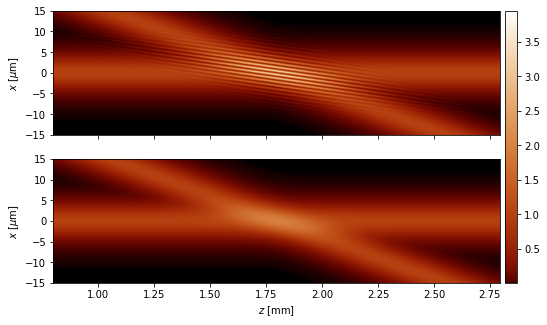

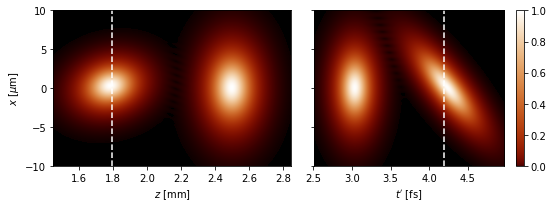

In [9]:
from pypropagate import *
from pypropagate.fit import fit_gaussians
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pypropagate.colormaps import fire_colormap

# Parameters
FWHM_t = 0.3 * units.fs
alpha = 0.02
l = 4 * FWHM_t * units.c / (pc.cos(alpha)**-1 - 1)
h = pc.tan(alpha) * l
stretch = 2000

# Create settings
settings = presets.settings.create_2D_paraxial_frequency_settings()
s = settings.symbols

# Define gaussian beam
g = settings.create_category('gaussian',info='Parameters of the gaussian beam')
g.create_symbol('sigma_x',info = 'Waist size at z = 0',type=pc.Types.Real,positive=True)
g.create_function('w_x',(s.z,),pc.sqrt(2)*pc.sqrt(g.sigma_x**2-1j/s.k*s.z),info = 'Waist size')
g.create_function('u',(s.x,s.z),g.sigma_x/g.w_x*pc.exp(-s.x**2/(g.w_x**2)));

# Define gaussian pulses
p1 = settings.create_category('pulse_1')
p1.create_symbol('sigma_t')
p1.create_symbol('omega_0')
p1.create_symbol('sigma_omega',1/p1.sigma_t)
p1.create_function('utilde_0',(s.x,s.z,s.omega),pc.exp(-1*(s.omega - p1.omega_0)**2 /(2*p1.sigma_omega**2)) * g.u  )
p1.create_symbol('alpha',0)
xa,za = pc.cos(p1.alpha)*s.x-pc.sin(p1.alpha)*s.z,pc.cos(p1.alpha)*s.z+pc.sin(p1.alpha)*s.x
p1.create_function('utilde',(s.x,s.z,s.omega),p1.utilde_0.function(xa,za,s.omega) * pc.exp(-1j*s.k*(za - s.z) ))
p2 = settings.create_category('pulse_2')
p2.create_symbol('sigma_t')
p2.create_symbol('omega_0')
p2.create_symbol('sigma_omega',1/p2.sigma_t)
p2.create_function('utilde_0',(s.x,s.z,s.omega),pc.exp(-1*(s.omega - p2.omega_0)**2 /(2*p2.sigma_omega**2)) * g.u  )
p2.create_symbol('alpha',0)
xa,za = pc.cos(p2.alpha)*s.x-pc.sin(p2.alpha)*s.z,pc.cos(p2.alpha)*s.z+pc.sin(p2.alpha)*s.x
p2.create_function('utilde',(s.x,s.z,s.omega),p2.utilde_0.function(xa,za,s.omega) * pc.exp(-1j*s.k*(za - s.z) ))

# Set parameters
g.sigma_x = h/10
p1.sigma_t = FWHM_t * pc.sqrt(2)/ (2 * pc.sqrt(2*pc.log(2)))
p1.omega_0 = 12 * units.keV/units.hbar
p1.alpha = -alpha
p2.sigma_t = FWHM_t * pc.sqrt(2)/ (2 * pc.sqrt(2*pc.log(2)))
p2.omega_0 = 12 * units.keV/units.hbar
p2.alpha = 0 * units.degrees
s.n = 1
s.u0 = p1.utilde.subs(s.x,s.x-h) + p2.utilde
s.u_boundary = pc.piecewise( ( s.u0,s.x>0), (0,True) )
s.omegamin = p1.omega_0 - 20 * p1.sigma_omega
s.omegamax = p1.omega_0 + 20 * p1.sigma_omega
s.xmin = -h * 1.5
s.xmax = h * 1.5
s.zmin = 0
s.zmax = 2*l
s.Nomega = 2**8
s.Nx = 2**17
s.Nz = 1000
print "domega = %f FWHM_omega" % settings.get_numeric(s.domega / (p1.sigma_omega * 2*(2*pc.log(2))**0.5))
print "dx = %f nm" % settings.get_numeric(s.dx / units.nm )
print "dz = %f um" % settings.get_numeric(s.dz / units.um )

# Propagate
propagator = propagators.Fresnel3D(settings)
u = propagator.run_slice()[::s.sx/1000,:,:]
t = pc.Symbol('t')
tdfield = presets.time.periodic_envelope_propagation(u,p1.omega_0,s=float(stretch)).transpose((t,s.x,s.z))

# Plot
time_averaged_intensity = (abs(tdfield)**2).sum(axis=t)
time_averaged_intensity /= time_averaged_intensity[:,0].max()
monochromatic_intensity = abs(u[:,(s.omegamin + s.omegamax)/2,:])**2
monochromatic_intensity /= monochromatic_intensity[:,0].max()
vmax = monochromatic_intensity.max()
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,5),sharex=True)
im1 = plot(monochromatic_intensity[-15*units.um:15*units.um,s.sz/2-1*units.mm:s.sz/2+1*units.mm],ax=ax1,vmax=vmax,cmap=fire_colormap())
ax1.set_xlabel('')
im2 = plot(time_averaged_intensity[-15*units.um:15*units.um,s.sz/2-1*units.mm:s.sz/2+1*units.mm],ax=ax2,vmax=vmax,cmap=fire_colormap())
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.125, 0.02, 0.755])
fig.colorbar(im1, cax=cbar_ax)
plt.savefig('plots/validation/angled_gaussian_pulses_xz.pdf',transparent=True)
t_cut = l/pc.cos(alpha)/units.c - (1-1./stretch) * l / units.c
z_cut = s.zmin + s.sz/2
cut_int_1 = (abs(tdfield[2.5*units.fs:5*units.fs,-10*units.um:10*units.um,z_cut])**2).transpose()
cut_int_1 /= cut_int_1.max()
cut_int_2 = abs((tdfield[t_cut,-10*units.um:10*units.um,1.45*units.mm:2.85*units.mm]))**2
cut_int_2 /= cut_int_2.max()
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3),sharey=True)
im = plot(cut_int_2,ax=ax1,cmap=fire_colormap(),vmax=1)
im = plot(cut_int_1,ax=ax2,cmap=fire_colormap(),vmax=1)
ax2.plot([settings.get_as(t_cut/units.fs,float)] * 2,[-10,10],'w--')
ax1.plot([settings.get_as(z_cut/units.mm,float)] * 2,[-10,10],'w--')
ax1.set_ylim(-10,10)
ax2.set_ylabel('')
ax2.set_xlabel(r"$t' \; [\mathrm{fs}]$")
plt.colorbar(im)
plt.tight_layout()
plt.savefig('plots/validation/angled_gaussian_pulses_xzt.pdf',transparent=True)

# Fit the time delay
popt,psig = fit_gaussians(abs(tdfield[2.5*units.fs:5*units.fs,0,z_cut])**2,2,periodic=True)
print "dt = %f fs +- %f fs" % ((popt[0][1] - popt[1][1])/units.fs,pc.sqrt((psig[0][1]/units.fs)**2+(psig[1][1]/units.fs)**2))
popt,psig = fit_gaussians(abs(tdfield[t_cut,0,:])**2,1,periodic=True)
print "FWHM_z = %f um +- %f um" % ((popt[0][2]*2*pc.sqrt(2*pc.log(2))/units.um,psig[0][2]*2*pc.sqrt(2*pc.log(2))/units.um))

## Gaussian pulse width

domega = 0.066613 FWHM_omega
dz = 100.100100 um
propagating:|███████████████████████| 999/999 [0.5s < 0(0)s]]
max width deviation: 0.010444 %


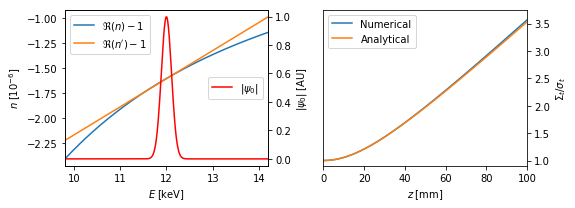

In [10]:
from pypropagate import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

# Create settings
settings = presets.settings.create_2D_paraxial_frequency_settings()
s = settings.symbols

# Define the pulse
p = settings.create_category('pulse_1')
p.create_symbol('sigma_t')
p.create_symbol('omega_0')
p.create_symbol('sigma_omega',1/p.sigma_t)
p.create_function('u_0',(s.x,s.z,s.omega),pc.exp(-1*(s.omega - p.omega_0)**2 /(2*p.sigma_omega**2))  )
presets.boundaries.set_plane_wave_initial_conditions(settings)
s.u0 = p.u_0

FWHM_t = 0.01 * units.fs
p.sigma_t = FWHM_t * pc.sqrt(2)/ (2 * pc.sqrt(2*pc.log(2)))
p.omega_0 = 12 * units.keV/units.hbar
s.omegamin = p.omega_0 - 20 * p.sigma_omega
s.omegamax = p.omega_0 + 20 * p.sigma_omega
s.Nomega = 2**8

# Taylor the refractive index of water
n = presets.medium.create_material('H2O',settings,density=1)
domega = 100*s.domega
n0 = settings.get_numeric(n.subs(s.omega,p.omega_0)).N()
n1 = settings.get_numeric(n.subs(s.omega,p.omega_0+domega)).N()
nn1 = settings.get_numeric(n.subs(s.omega,p.omega_0-domega)).N()
dn0 = (n1 - nn1)/(2*domega)
n_taylored = n0 + (s.omega - p.omega_0) * dn0 
s.n = n_taylored
s.xmin = -1*units.nm
s.xmax = 1*units.nm
s.zmin = 0
s.zmax = 100*units.mm
s.Nx = 5
s.Nz = 1000
print "domega = %f FWHM_omega" % settings.get_numeric(s.domega / (p1.sigma_omega * 2*(2*pc.log(2))**0.5))
print "dz = %f um" % settings.get_numeric(s.dz / units.um )

# Propagate and Fourier transform
propagator = propagators.Fresnel3D(settings)
field = propagator.run_slice()[0,:]
tdfield = presets.time.periodic_envelope_propagation(field,p.omega_0,s=1).transpose()

# Fit gaussian profiles to the beam shape
widths = []
intensities = []
indices = []
offsets = []
xdata = np.linspace(float((tdfield.bounds[1][0])/units.fs) , float((tdfield.bounds[1][1])/units.fs) , tdfield.shape[1])
gaussian = lambda x,x0,s,a: a * np.exp(-(x-x0)**2 / (2*s**2))
for i in range(tdfield.shape[0]):
    ydata = abs(tdfield.data[i])
    ymax = ydata.max()
    ydata = np.roll(ydata,ydata.shape[0]/2 - np.where(ydata==ydata.max())[0]) 
    p0 = [xdata[len(xdata)/2],(xdata[-1]-xdata[0])/40,ymax]
    popt, pcov = curve_fit(gaussian, xdata, ydata,p0=p0)
    offsets.append(popt[0])
    widths.append(abs(popt[1]))
    intensities.append(popt[2])
    indices.append(i)
dz = settings.get_as(s.dz/units.mm,float)
zvalues = np.array([i*dz for i in indices])
widths = np.array(widths)/widths[0]

# Analytical solution
omega0 = p.omega_0
K0 = n0 * omega0/units.c
K1 = (n0 + omega0 * dn0)/units.c
K2 = 2*dn0/units.c
sigma_t = p.sigma_t
zprime = zvalues * complex(settings.get_numeric(units.mm*pc.imag(K2)/sigma_t**2)).real
gamma = complex(settings.get_numeric(pc.real(K2)/pc.imag(K2))).real
analytical_widths = np.sqrt(((1+zprime**2)+(zprime*gamma)**2)/(1+zprime))
print 'max width deviation: %f %%' % abs((np.array(widths) - analytical_widths) / analytical_widths).max()

# Plot
fig,(ax2,ax1) = plt.subplots(1,2,figsize=(8,3))
ax1.plot(zvalues,widths,label='Numerical')
ax1.plot(zvalues,analytical_widths,label='Analytical')
ax1.legend(loc=2)
ax1.set_xlim(0.,100)
ax1.set_ylim(0.9,3.75)
ax1.set_xlabel(r"$z \; [\mathrm{mm}]$")
ax1.set_ylabel(r"$\Sigma_t/\sigma_t$")
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
n_plot = expression_to_array(n,settings)
n_taylored_plot = expression_to_array(n_taylored,settings)
u0_plot = expression_to_array(s.u0,settings)
E_plot = expression_to_array(s.E/units.keV,settings).real
ax2.plot(E_plot.data,(n_plot.data.real-1) * 1e6,label='$\Re(n)-1$')
ax2.plot(E_plot.data,(n_taylored_plot.data.real-1) * 1e6,label=r"$\Re(n')-1$")
ax2.set_ylabel(r'$n \; [10^{-6}]$')
ax2.set_xlabel('$E\;[\mathrm{keV}]$')
ax3 = ax2.twinx()
ax3.plot(E_plot.data,abs(u0_plot.data),color='r',label='$|\psi_0|$')
ax3.set_ylabel(r'$|\psi_0| \; [\mathrm{AU}]$')
ax2.set_xlim(9.8,14.2)
ax2.set_xticks(range(10,15))
ax2.legend(loc=2,prop={'size':10})
ax3.legend(loc=5,prop={'size':10})
plt.tight_layout()
plt.savefig('plots/validation/gaussian_pulse_width_comparison.pdf',bbox_extra_artists=(ax2,ax3),transparent=True)

## Waveguide pulses

slab
domega = 0.066613 FWHM_omega
dx = 0.195360 nm
dz = 0.366233 um
stretch = 66712.819040
propagating:|███████████████████| 1023/1023 [238.4s < 0(0)s]]
mode 0:
  v = (1-1.80418e-07) c
  s = 1.006 +- 0.004
mode 1:
  v = (1-1.01526e-06) c
  s = 1.023 +- 0.004
mode 2:
  v = (1-2.59569e-06) c
  s = 1.122 +- 0.002
circ
domega = 0.066613 FWHM_omega
dx = 0.195360 nm
dz = 0.366233 um
stretch = 66712.819040
propagating:|███████████████████| 1023/1023 [379.9s < 0(0)s]]
mode 0:
  v = (1-3.21988e-07) c
  s = 1.007 +- 0.005
mode 1:
  v = (1-1.35786e-06) c
  s = 1.037 +- 0.001
mode 2:
  v = (1-3.06822e-06) c
  s = 1.166 +- 0.006
curved
domega = 0.066613 FWHM_omega
dx = 0.195360 nm
dz = 0.366233 um
stretch = 66712.819040
propagating:|███████████████████| 1023/1023 [340.9s < 0(0)s]]
mode 0:
  v = (1-1.13284e-06) c
  s = 1.172 +- 0.002


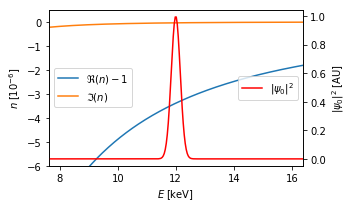

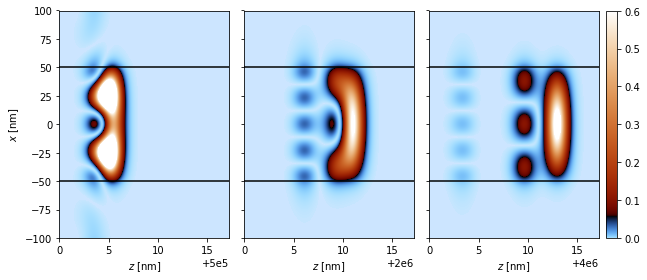

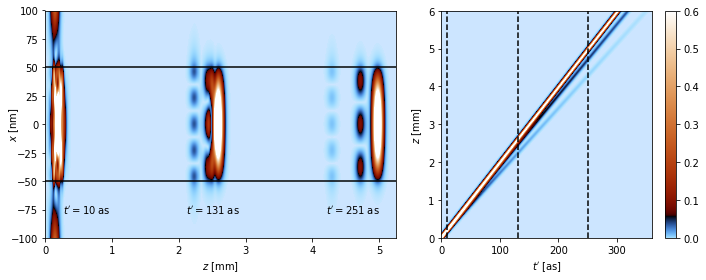

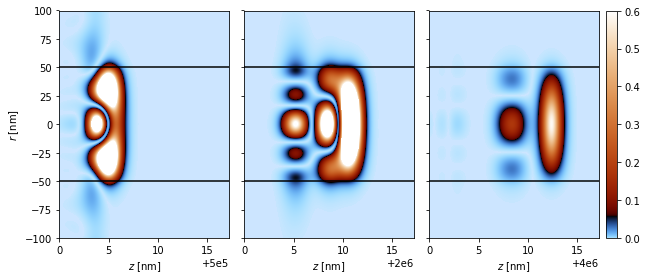

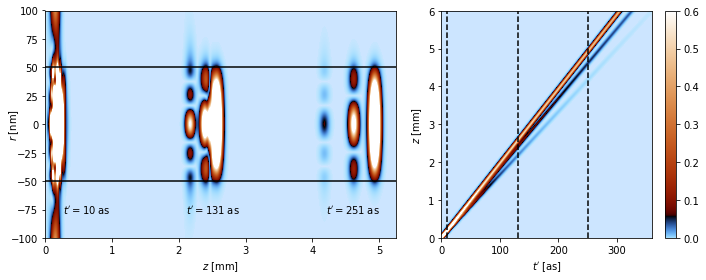

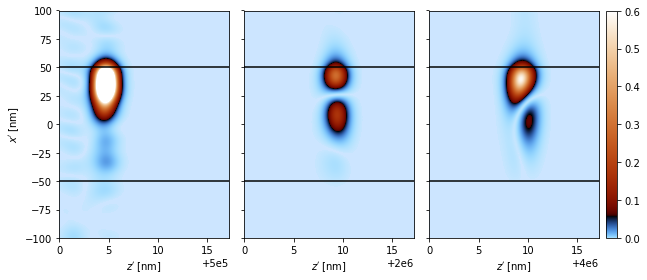

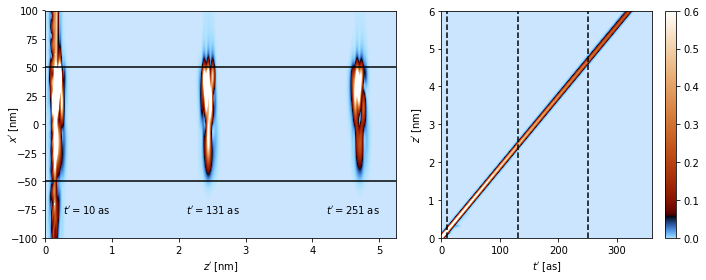

In [11]:
from pypropagate import *
from pypropagate.colormaps import ice_and_fire_colormap
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pypropagate.fit import fit_gaussians

def pulsed_waveguide_propagation(wg_type): # wg_type in {'slab','circ','curved'}
    print wg_type

    # Create the settings
    settings = presets.settings.create_2D_paraxial_frequency_settings()
    s = settings.symbols

    # Define the pulse parameters
    p = settings.create_category('pulse')
    p.create_symbol('FWHM_t') # width in intensity
    p.create_symbol('sigma_t',p.FWHM_t * pc.sqrt(2)/(2 * pc.sqrt(2*pc.log(2))))
    p.create_symbol('omega_0')
    p.create_symbol('sigma_omega',1/p.sigma_t)
    p.create_function('u_0',(s.x,s.z,s.omega),pc.exp(-1*(s.omega - p.omega_0)**2 /(2*p.sigma_omega**2))  )
    presets.boundaries.set_plane_wave_initial_conditions(settings)

    # Define the waveguide parameters
    wg = settings.create_category('waveguide')
    wg.create_symbol('d')
    wg.create_function('n_cladding',(s.omega,))
    wg.create_function('n_core',(s.omega,))
    wg.create_function('n',(s.x,s.z,s.omega,), pc.piecewise((wg.n_core,2*abs(s.x) < wg.d),(wg.n_cladding,True)))

    # Set parameters
    s.u0 = p.u_0
    p.omega_0 = 12*units.keV / units.hbar
    p.FWHM_t = 0.005*units.fs
    s.omegamin = p.omega_0 - 20 * p.sigma_omega
    s.omegamax = p.omega_0 + 20 * p.sigma_omega
    s.Nomega = 2**8
    wg.d = 100 * units.nm
    wg.n_core = 1
    wg.n_cladding = presets.medium.create_material('Si',settings)
    s.n = wg.n
    s.xmin = -400*units.nm
    s.xmax =  400*units.nm
    s.zmin = 0
    s.zmax = 6*units.mm
    s.Nx = 2**12
    s.Nz = 2**14
    pulse_length = settings.get_numeric(p.FWHM_t * units.c)
    stretch = float(settings.get_numeric(0.01 * 10 * units.mm / pulse_length))
    print "domega = %f FWHM_omega" % settings.get_numeric(s.domega / (p.sigma_omega * 2*(2*pc.log(2))**0.5))
    print "dx = %f nm" % settings.get_numeric(s.dx / units.nm )
    print "dz = %f um" % settings.get_numeric(s.dz / units.um )
    print "stretch = %f" % stretch

    if wg_type == 'curved':
        # Piecewise paraxial propagation
        def create_curvature_initializer(R):
            def curvature_initializer(settings):
                s = settings.symbols
                alpha = settings.get_as(-pc.atan(s.dz/R),float)
                update_field = expression_to_array(pc.exp(1j*s.k*s.x*pc.sin(alpha)),settings).data.transpose()
                def curvature_updater(propagator):
                    field = propagator._get_field()
                    field *= update_field
                settings.updaters['curvature_updater'] = curvature_updater
            return curvature_initializer

        n_padding = presets.medium.create_material('Ge',settings)
        s_padding = 200 * units.nm
        r = pc.Min(1,pc.Max(0,(s.x - s.xmax + s_padding) / s_padding))
        s.n = wg.n * (1-r) + r * n_padding
        settings.initializers['curvature'] = create_curvature_initializer(40 * units.mm)

    # Run simulation
    propagator_type = {'slab':propagators.FiniteDifferences3D,'circ':propagators.FiniteDifferences3DCS,'curved':propagators.FiniteDifferences3D}
    propagator = propagator_type[wg_type](settings)
    u = propagator.run_slice()[-wg.d:wg.d:2*wg.d/1024,:,::s.sz/1024]
    tdfield = presets.time.periodic_envelope_propagation(u,p.omega_0,s=stretch).transpose([pc.Symbol('t'),s.x,s.z])

    # Create large xz slice by stacking slice three times
    wg_field = tdfield[:,-wg.d/2:wg.d/2,:]
    if wg_type == 'circ':
        radius_wg = expression_to_array(abs(s.x/wg.d*2),settings)[-wg.d/2:wg.d/2].real
        intensity = abs(wg_field)**2
        intensity.data.transpose((2,0,1))[:] *= radius_wg.data

        sliced = (intensity).sum(axis=s.x)
        sliced /= wg_field.shape[1]
        del intensity
    else:
        sliced = (abs(wg_field)**2).sum(axis=s.x)
        sliced /= wg_field.shape[wg_field.axis.index(s.x)]
    stacked_data = np.vstack([sliced.data,sliced.data,sliced.data])
    stacked = CoordinateNDArray(stacked_data,[[sliced.bounds[0][0],sliced.bounds[0][1]*3],sliced.bounds[1]],sliced.axis,sliced.evaluate)

    # Remove periodic signals
    stacked[0.1*units.fs:,:1*units.mm].data[:] = 0
    stacked[0.15*units.fs:,:2*units.mm].data[:] = 0
    stacked[0.2*units.fs:,:2.5*units.mm].data[:] = 0
    stacked[0.225*units.fs:,:2.9*units.mm].data[:] = 0
    stacked[0.25*units.fs:,:4*units.mm].data[:] = 0
    stacked[0.31*units.fs:,:5*units.mm].data[:] = 0
    stacked[:0.08*units.fs,1.9*units.mm:].data[:] = 0
    stacked[:0.15*units.fs,3.1*units.mm:].data[:] = 0
    stacked[:0.2*units.fs,4.1*units.mm:].data[:] = 0
    stacked[:0.24*units.fs,5*units.mm:].data[:] = 0
    normalization = stacked[0].max()
    vmax = 0.6

    # Plot refractive index
    if wg_type == 'slab':
        fig,(ax2) = plt.subplots(1,1,figsize=(5,3))
        n_plot = expression_to_array(wg.n_cladding,settings)
        u0_plot = expression_to_array(s.u0,settings)
        E_plot = expression_to_array(s.E/units.keV,settings).real
        ax2.plot(E_plot.data,(n_plot.data.real-1) * 1e6,label='$\Re(n)-1$')
        ax2.plot(E_plot.data,(n_plot.data.imag) * 1e6,label='$\Im(n)$')
        ax2.set_ylabel(r'$n \; [10^{-6}]$')
        ax2.set_xlabel('$E\;[\mathrm{keV}]$')
        ax2.set_ylim(-6,0.5)
        ax3 = ax2.twinx()
        ax3.plot(E_plot.data,abs(u0_plot.data)**2,color='r',label='$|\psi_0|^2$')
        ax3.set_ylabel(r'$|\psi_0|^2 \; [\mathrm{AU}]$')
        ax2.set_xticks(range(4,20,2))
        ax2.set_xlim(E_plot.min(),E_plot.max())
        ax2.legend(loc=6,prop={'size':10})
        ax3.legend(loc=5,prop={'size':10})
        plt.tight_layout()
        plt.savefig('plots/time_dependent/n_Si_12keV_5as.pdf')

    # Plot
    def plot_intensity(pos,length,time,ax):
        exit_field_freq = CoordinateNDArray(np.repeat(u[:,:,pos].data[:,:,np.newaxis],100,axis=2),[u.bounds[0],u.bounds[1],[pos,pos + length]],u.axis,u.evaluate)
        exit_field = presets.time.periodic_envelope_propagation(exit_field_freq,p.omega_0,1).transpose([pc.Symbol('t'),s.x,s.z])
        im = plot((exit_field[time].real)**2/normalization,cmap=ice_and_fire_colormap(),vmax=vmax,ax=ax)
        ax.plot([float(b/units.nm) for b in exit_field.bounds[2]],[50]*2,'-',color='k')
        ax.plot([float(b/units.nm) for b in exit_field.bounds[2]],[-50]*2,'-',color='k')
        return im
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4),sharey=True)
    im = plot_intensity(0.5 * units.mm,11.5 * pulse_length,0.0175*units.fs,ax=ax1)
    plot_intensity(2 * units.mm,11.5 * pulse_length,0.0375*units.fs,ax=ax2)
    plot_intensity(4 * units.mm,11.5 * pulse_length,0.045*units.fs,ax=ax3)
    if wg_type == 'circ': ax1.set_ylabel('$r \; [\mathrm{nm}]$')
    if wg_type == 'curved': 
        ax1.set_ylabel(r"$x' \; [\mathrm{nm}]$")
        for ax in [ax1,ax2,ax3]: ax.set_xlabel(r"$z' \; [\mathrm{nm}]$")
    ax2.set_ylabel('')
    ax3.set_ylabel('')
    plt.tight_layout()
    fig.colorbar(im, ax=[ax1,ax2,ax3],pad=0.01)
    plt.savefig('plots/time_dependent/%s_waveguide_as_pulse_intensities.pdf' % wg_type)

    t0 = 0.01*units.fs
    t1 = t0 + tdfield.bounds[0][1]
    t2 = t0 + 2*tdfield.bounds[0][1]
    fig = plt.figure(figsize=(10,4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2,1.5])
    ax1 = plt.subplot(gs[1])
    im = plot(stacked.transpose()[:6*units.mm]/normalization,cmap=ice_and_fire_colormap(),ax=ax1,vmax=vmax)
    ax1.plot([float(t0*1e3/units.fs)] * 2,[0,6],'k--')
    ax1.plot([float(t1*1e3/units.fs)] * 2,[0,6],'k--')
    ax1.plot([float(t2*1e3/units.fs)] * 2,[0,6],'k--')
    ax1.set_xlim(0,360)
    ax1.set_ylim(0,6)
    cbar = plt.colorbar(im)
    plot_intensity = abs(tdfield[t0,:,:5.25*units.mm])**2
    ax2 = plt.subplot(gs[0])
    im = plot(plot_intensity/normalization,cmap=ice_and_fire_colormap(),ax=ax2,vmax=vmax)
    ax2.plot([0,6],[50,50],'-',color='k')
    ax2.plot([0,6],[-50,-50],'-',color='k')
    ax2.set_xlim(0,5.25)
    ax2.text(0.27,-75,"$t' = %.0f \; \mathrm{as}$" % (t0*1000/units.fs),horizontalalignment='left',verticalalignment='center')
    ax2.text(2.1,-75,"$t' = %.0f \; \mathrm{as}$" % (t1*1000/units.fs),horizontalalignment='left',verticalalignment='center')
    ax2.text(4.2,-75,"$t' = %.0f \; \mathrm{as}$" % (t2*1000/units.fs),horizontalalignment='left',verticalalignment='center')
    ax2.yaxis.labelpad = -10
    if wg_type == 'circ': ax2.set_ylabel('$r \; [\mathrm{nm}]$')
    if wg_type == 'curved': 
        ax2.set_ylabel(r"$x' \; [\mathrm{nm}]$")
        ax2.set_xlabel(r"$z' \; [\mathrm{nm}]$")
        ax1.set_ylabel(r"$z' \; [\mathrm{nm}]$")
    ax1.set_xlabel(r"$t' \; [\mathrm{as}]$")
    plt.tight_layout()
    plt.savefig('plots/time_dependent/mode_group_velocities_%s_waveguide.pdf' % wg_type)

    # Determine goup velocities
    zfit = stacked._dbounds[1] * stacked.shape[1] * 0.8
    NM = 1 if wg_type == 'curved' else 3
    popt,psig = fit_gaussians(stacked[:,zfit].transpose(),NM)
    for i,v,s in zip(range(NM),popt,psig):
        print 'mode %i:' % i
        print "  v = (1-%.5e) c" % ( 1 - zfit/(v[1] + zfit/units.c * (1-1./stretch)) / units.c)
        print "  s = %.3f +- %.3f" % tuple(settings.get_as( (v[2]*pc.sqrt(2)/(p.sigma_t) , s[2]*pc.sqrt(2)/p.sigma_t) , float))                      
                       
pulsed_waveguide_propagation('slab')
pulsed_waveguide_propagation('circ')
pulsed_waveguide_propagation('curved')

propagating:|█████████████████████| 999/999 [489.3s < 0(0)s]]
propagating:|█████████████████████| 999/999 [579.5s < 0(0)s]]
propagating:|███████████████████████| 999/999 [0.6s < 0(0)s]]


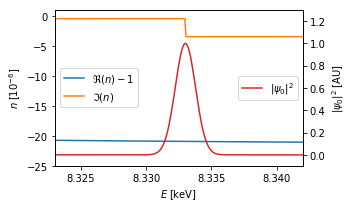

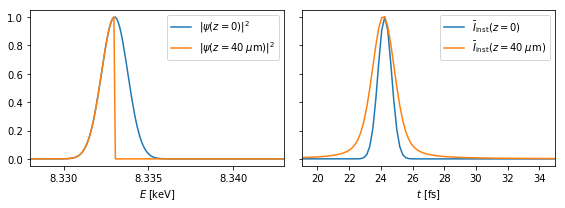

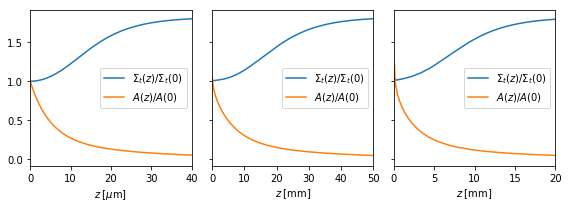

In [12]:
from pypropagate import *
import matplotlib.pyplot as plt
from lmfit.models import VoigtModel

settings = presets.settings.create_2D_paraxial_frequency_settings()
pde = settings.partial_differential_equation
s = settings.symbols

p = settings.create_category('pulse')
p.create_symbol('FWHM_t')
p.create_symbol('sigma_t',p.FWHM_t * pc.sqrt(2)/(2 * pc.sqrt(2*pc.log(2))))
p.create_symbol('omega_0')
p.create_symbol('sigma_omega',1/p.sigma_t)
p.create_function('u_0',(s.x,s.z,s.omega),pc.exp(-1*(s.omega - p.omega_0)**2 /(2*p.sigma_omega**2))  )
wg = settings.create_category('waveguide')
wg.create_function('n_core',(s.omega,))
wg.create_function('n_cladding',(s.omega,))
wg.create_symbol('r')

s.u0 = p.u_0
presets.boundaries.set_1D_boundary_condition(settings)
wg.n_core = 1
wg.n_cladding = presets.medium.create_material('Ni',settings)
wg.r = 50*units.nm
p.FWHM_t = 1 * units.fs 
p.omega_0 = 8.333*units.keV/units.hbar
s.omegamin = p.omega_0 - 10 * p.sigma_omega
s.omegamax = p.omega_0 + 10 * p.sigma_omega
s.Nomega = 2**8
s.xmin = -0.1* units.um
s.xmax = 0.1 * units.um
s.zmin = 0
s.zmax = 50*units.mm
s.Nx = 1000
s.Nz = 100000
s.n = pc.piecewise((wg.n_core,abs(s.x) <= wg.r),(wg.n_cladding,True))

# Function to center periodic data
centered = lambda field: np.roll(field,field.shape[0]/2 - np.where(field == field.max())[0][0])

# Function to determine pulse width and intensity
def get_wi(int_field):
    xdata = np.linspace(float((int_field.bounds[0][0])/units.fs) , float((int_field.bounds[0][1])/units.fs) , int_field.shape[0])
    widths = []
    intensities = []
    mod = VoigtModel()
    for i in range(int_field.shape[1]):
        ydata = centered(int_field.data[:,i])
        ymax = ydata.max()
        pars = mod.guess(ydata, x=xdata)
        out = mod.fit(ydata, pars, x=xdata)    
        widths.append(out.result.params.get('fwhm').value)
        intensities.append(out.result.params.get('height').value)
    return np.array(widths),np.array(intensities)

# Slab waveguide
propagator = propagators.FiniteDifferences3D(settings)
u = propagator.run_slice()[-2*wg.r:2*wg.r:4*wg.r/1000,:,::s.sz/1000]
tdfield = presets.time.periodic_envelope_propagation(u,p.omega_0).transpose([pc.Symbol('t'),s.x,s.z])
wg_field = tdfield[:,-wg.r:wg.r]
int_field = (abs(wg_field)**2).sum(axis=s.x)
slab_w,slab_i = get_wi(int_field)
dz = float(int_field._dbounds[1]/units.mm)
zvalues = np.array([i*dz for i in range(int_field.shape[1])])

# Circular waveguide
propagator = propagators.FiniteDifferences3DCS(settings)
u = propagator.run_slice()[-2*wg.r:2*wg.r:4*wg.r/1000,:,::s.sz/1000]
tdfield = presets.time.periodic_envelope_propagation(u,p.omega_0).transpose([pc.Symbol('t'),s.x,s.z])
wg_field = tdfield[:,-wg.r:wg.r,:]
radius_wg = expression_to_array(abs(s.x/wg.r),settings)[-wg.r:wg.r].real
int_field = abs(wg_field)**2
int_field.data.transpose((2,0,1))[:] *= radius_wg.data
circ_w,circ_i = get_wi(int_field.sum(axis=s.x))

# Homogeneous medium
s.n = wg.n_cladding
s.Nx = 4
s.Nz = 1000
s.zmax = 0.1*units.mm
propagator = propagators.Fresnel3D(settings)
u = propagator.run_slice()[-2*wg.r:2*wg.r:4*wg.r/1000,:,::s.sz/1000]
tdfield = presets.time.periodic_envelope_propagation(u,p.omega_0).transpose([pc.Symbol('t'),s.x,s.z])
int_field = abs(tdfield[:,0,:])**2
hom_w,hom_i = get_wi(int_field)
hom_dz = float(int_field._dbounds[1]/units.um)
hom_zvalues = np.array([i*hom_dz for i in range(int_field.shape[1])])

# Plot refractive index
E_plot = expression_to_array(s.E/units.keV,settings).data.real
n_plot = expression_to_array(wg.n_cladding,settings).data
u0_plot = expression_to_array(s.u0,settings).data
fig,ax3 = plt.subplots(figsize=(5,3))
ax4 = ax3.twinx()
ax3.plot(E_plot,(n_plot.real-1)*10**6,label='$\Re(n) - 1$')
ax3.plot(E_plot,n_plot.imag*10**6,label='$\Im(n)$')
ax3.set_ylim(-25,1)
ax3.set_xlabel(r'$E \; [\mathrm{keV}]$')
ax3.set_ylabel(r'$n \; [10^{-6}]$')
ax3.legend(loc=6)
ax3.set_xticks([8.325,8.33,8.335,8.34])
ax3.set_xlim(8.323,8.342)
ax4.plot(E_plot,abs(u0_plot)**2,color='C3',label='$|\psi_0|^2$')
ax4.set_ylabel(r'$|\psi_0|^2\;[\mathrm{AU}]$')
ax4.set_ylim(-0.1,1.3)
ax4.legend(loc=5)
plt.tight_layout()
plt.savefig('plots/time_dependent/Ni_8keV_300as.pdf',transparent=True)

# Plot beam shape
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3),sharey=True)
ax1.plot(E_plot,abs(u[0,:,0].data)**2,label='$|\psi(z=0)|^2$')
ax1.plot(E_plot,abs(u[0,:,40*units.um].data)**2/(abs(u[0,:,40*units.um].data)**2).max(),label='$|\psi(z=40\;\mu\mathrm{m})|^2$')
ax1.set_xlabel(r'$E \; [\mathrm{keV}]$')
ax1.set_xticks([8.32 + 0.005 * i for i in range(10)])
ax1.set_xlim(8.328,8.343)
ax1.legend()
plot(centered(int_field[:,0]/int_field[:,0].max()),ax=ax2,label=r'$\bar{I}_\mathrm{inst}(z=0)$')
plot(centered(int_field[:,40*units.um]/int_field[:,40*units.um].max()),ax=ax2,label=r'$\bar{I}_\mathrm{inst}(z=40\;\mu\mathrm{m})$')
ax2.set_xlim(19,35)
ax2.legend(loc=1)
plt.tight_layout()
plt.savefig('plots/time_dependent/Ni_propagation_pulse_shape_and_spectrum.pdf',transparent=True)

# Plot widths
fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(8,3))
ax1.plot(hom_zvalues,hom_w/hom_w[0],label=r'$\Sigma_t(z) / \Sigma_t(0)$')
ax1.plot(hom_zvalues,hom_i/hom_i[0],label=r'$A(z) / A(0)$')
ax1.set_xlim(0,40)
ax1.legend(loc=5)
ax1.set_xlabel(r'$z\;[\mu \mathrm{m}]$')
ax2.plot(zvalues,slab_w/slab_w[0],label=r'$\Sigma_t(z) / \Sigma_t(0)$')
ax2.plot(zvalues,slab_i/slab_i[0],label=r'$A(z) /A(0)$')
ax2.legend(loc=5)
ax2.set_xlabel(r'$z\;[\mathrm{mm}]$')
ax2.set_xlim(0,50)
ax3.plot(zvalues,circ_w/circ_w[0],label=r'$\Sigma_t(z) / \Sigma_t(0)$')
ax3.plot(zvalues,circ_i/circ_i[0],label=r'$A(z) / A(0)$')
ax3.legend(loc=5)
ax3.set_xlabel(r'$z\;[\mathrm{mm}]$')
ax3.set_xlim(0,20)
plt.tight_layout()
plt.savefig('plots/time_dependent/pulse_width_Ni_absorption_edge_100nm_wg_comparison.pdf',transparent=True)